# Med MNIST

### Data Loading && Prepare

In [54]:
!pip3 install torch tqdm torchsummary torchvision fastprogress matplotlib pandas scikit-learn torchmetrics timm numpy albumentations scikit-image --quiet

In [38]:
import pandas as pd
import os

In [39]:
path = "./MedMNIST"
classes = os.listdir(path)
print(classes)

['Hand', 'BreastMRI', 'ChestCT', 'HeadCT', 'AbdomenCT', 'CXR']


In [74]:
import torch

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [69]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
dataset=ImageFolder(path,ToTensor())
dataset

Dataset ImageFolder
    Number of datapoints: 58954
    Root location: ./MedMNIST
    StandardTransform
Transform: ToTensor()

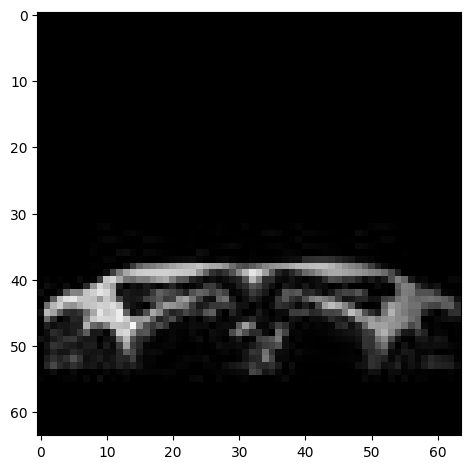

In [67]:
import matplotlib.pyplot as plt
import skimage.io as io
io.imshow('./MedMNIST/BreastMRI/000010.jpeg');

In [68]:
from albumentations.pytorch import ToTensorV2

imgSize = 64

train_transform = A.Compose([
    A.ColorJitter(p=0.8),
    A.HorizontalFlip(),
    A.GaussNoise(p=0.1),
    A.RandomRotate90(),
    A.Normalize(),
    ToTensorV2()
])
test_transform = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

In [71]:
train_set,test_set,valid_set=torch.utils.data.random_split(dataset,[50000,6000,2954])

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, shuffle=True,batch_size = 16)
test_loader = DataLoader(test_set, batch_size = 16)
valid_loader = DataLoader(valid_set, batch_size = 16)

In [ ]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

In [101]:
import timm
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np

In [104]:
num_classes = len(classes)
print(num_classes)

model = timm.create_model('resnet34', pretrained=True, num_classes=num_classes)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

6


In [105]:
model.to(device)
print('Done')

Done


In [ ]:
Accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)
Precision = MulticlassPrecision(num_classes=num_classes).to(device)
Recall = MulticlassRecall(num_classes=num_classes).to(device)

In [ ]:

for e in range(10):
    print(f"Epoch: {e + 1}")
    loss_train = []
    loss_test = []
    model.train()
    for x, y in tqdm(train_loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        predict = model(x)
        l = loss_f(predict, y)
        l.backward()
        loss_train.append(float(l.item()))
        optimizer.step()

        Accuracy.update(predict, y)
        Precision.update(predict, y)
        Recall.update(predict, y)
    print("Acc: ", Accuracy.compute())
    print("Prec: ", Precision.compute())
    print("Rec: ", Recall.compute())

    print(np.mean(loss_train))
    model.eval()
    for x, y in tqdm(test_loader):
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            predict = model(x)
            l = loss_f(predict, y)
            loss_test.append(float(l.item()))
            Accuracy.update(predict, y)
            Precision.update(predict, y)
            Recall.update(predict, y)
    print("Acc: ", Accuracy.compute())
    print("Prec: ", Precision.compute())
    print("Rec: ", Recall.compute())
    print(np.mean(loss_test))

Epoch: 1


 15%|█▍        | 456/3125 [02:52<17:55,  2.48it/s]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_train)

### Gini index

# Gini = AUC * 2 - 1

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

for name, X, y, model in [
    ('train', X_train_bow, labels, bow_model),
    ('test ', X_test_bow, labels_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

print('train accuracy', accuracy_score(model.predict(X_train_bow), labels))
print('test accuracy', accuracy_score(model.predict(X_test_bow), labels_test))



In [ ]:
gini = roc_auc_score * 2 - 1
gini